# Load the Dataset

These datasets can be found at: https://support.10xgenomics.com/single-cell-gene-expression/datasets under the heading **Single Cell 3' Paper: Zheng et al. 2017**. Please replace ``path_prefix`` to the location where you have downloaded the files.

In [6]:
import numpy as np, h5py, os
import matplotlib.pyplot as plt
from operator import itemgetter 
from scipy.sparse import vstack, coo_matrix, csc_matrix, isspmatrix_csc
%matplotlib inline

fnames = ['293t',           #0
          'aml027_post',    #1
          'aml027_pre',     #2
          'aml035_post',    #3
          'aml035_pre',     #4
          'b',              #5
          'bmmc_healthy_1', #6
          'bmmc_healthy_2', #7
         ] 

path_prefix = 'C:/Users/aabid/OneDrive/' #Replace with your own path

path_suffix = '/filtered_matrices_mex/hg19/matrix.mtx'

For faster access, save all of the files as h5py files.

In [ ]:
def gen_path(fname):
    return path_prefix + fname + path_suffix

for fname in fnames:
    if not(os.path.isfile(path_prefix+fname+'.h5')): # returns whether the h5 file exists or not    
        data = np.genfromtxt(gen_path(fname),delimiter=' ',skip_header=3,filling_values=0)
        row = data[:,1]-1 #1-indexed
        col = data[:,0]-1 #1-indexed
        values = data[:,2]
        print('Filename read:',fname)
        with h5py.File(path_prefix+fname+'.h5', 'w') as hf:
            hf.create_dataset("filtered_matrix",  data=data)    
        print('Filename written:',fname)

# Preprocess to Reduce Num of Genes

This is a helper class that loads the files, preprocesses them, and then separates them into target and background datasets. This will be useful, since we are running PCA and cPCA, on multiple sets of target files. The Dataset class contains methods to perform standard and contrastive PCA.

In [7]:
from utils import Dataset
%matplotlib inline

class SingleCell(Dataset):

    def __init__(self, active_files, background_file, N_GENES = 500, to_standardize=True, verbose=True): 
        self.active = vstack([self.file_to_features(fname) for fname in active_files])
        self.bg = vstack([self.file_to_features(fname) for fname in background_file])
        self.reduce_features(N_GENES)
        self.data = np.concatenate((self.active, self.bg),axis=0)
        self.active_labels = np.concatenate([self.file_to_labels(fname, l) for l, fname in enumerate(active_files)])
                
        # Pre-processing - done in main class
        if (verbose):
            print("Data size\t\t", self.data.shape)
            print("Active dataset size: \t", self.active.shape)
            print("Background dataset size:", self.bg.shape)
        super(self.__class__, self).__init__(to_standardize=to_standardize)
        self.pca_active()
        
    def description():
        print("To Add")
        
    def file_to_features(self, fname):
        with h5py.File(path_prefix+fname+'.h5', 'r') as hf:
            data = hf['filtered_matrix'][:]
        row = data[:,1]-1 #1-indexed
        col = data[:,0]-1 #1-indexed
        values = data[:,2]
        c = csc_matrix((values, (row, col)), shape=(row.max()+1, col.max()+1))
        return c
    
    def reduce_features(self, N_GENES):
        n_active = self.active.shape[0]
        n_bg     = self.bg.shape[0]
        c = vstack((self.active, self.bg), format="csc")
        nonzero_idx = np.where(np.amax(c, axis=0).toarray().flatten()>0)[0]
        c = c[:,nonzero_idx]
        c = c.toarray()
        total_dispersion = np.var(c,axis=0)/np.mean(c,axis=0)
        ind = np.argpartition(total_dispersion, -N_GENES)[-N_GENES:].flatten()
        c = c[:,ind]
        self.active = c[:n_active]
        self.bg     = c[-n_bg:]

    def file_to_labels(self, fname, l):
        with h5py.File(path_prefix+fname+'.h5', 'r') as hf:
            data = hf['filtered_matrix'][:]
        row = data[:,1]-1 #1-indexed
        col = data[:,0]-1 #1-indexed
        values = data[:,2]
        c = coo_matrix((values, (row, col)), shape=(row.max()+1, col.max()+1))
        c = c.toarray()
        num_cells = c.shape[0]
        labels = np.repeat([l], num_cells)
        return labels    

# Run Standard and Contrastive PCA (2 Groups)

In [ ]:
import matplotlib

active_file_idx = [1,2]
dataset = SingleCell(itemgetter(*active_file_idx)(fnames), [fnames[6]])
colors = ['#1f77b4','#d62728', '#2ca02c', '#ff7f0e']

projected_data, alphas = dataset.automated_cpca(max_log_alpha=3)
active_labels = dataset.get_active_labels()

0.0
0.0
3.45510729459
3.45510729459
28.9426612472
28.9426612472
388.815518031
388.815518031


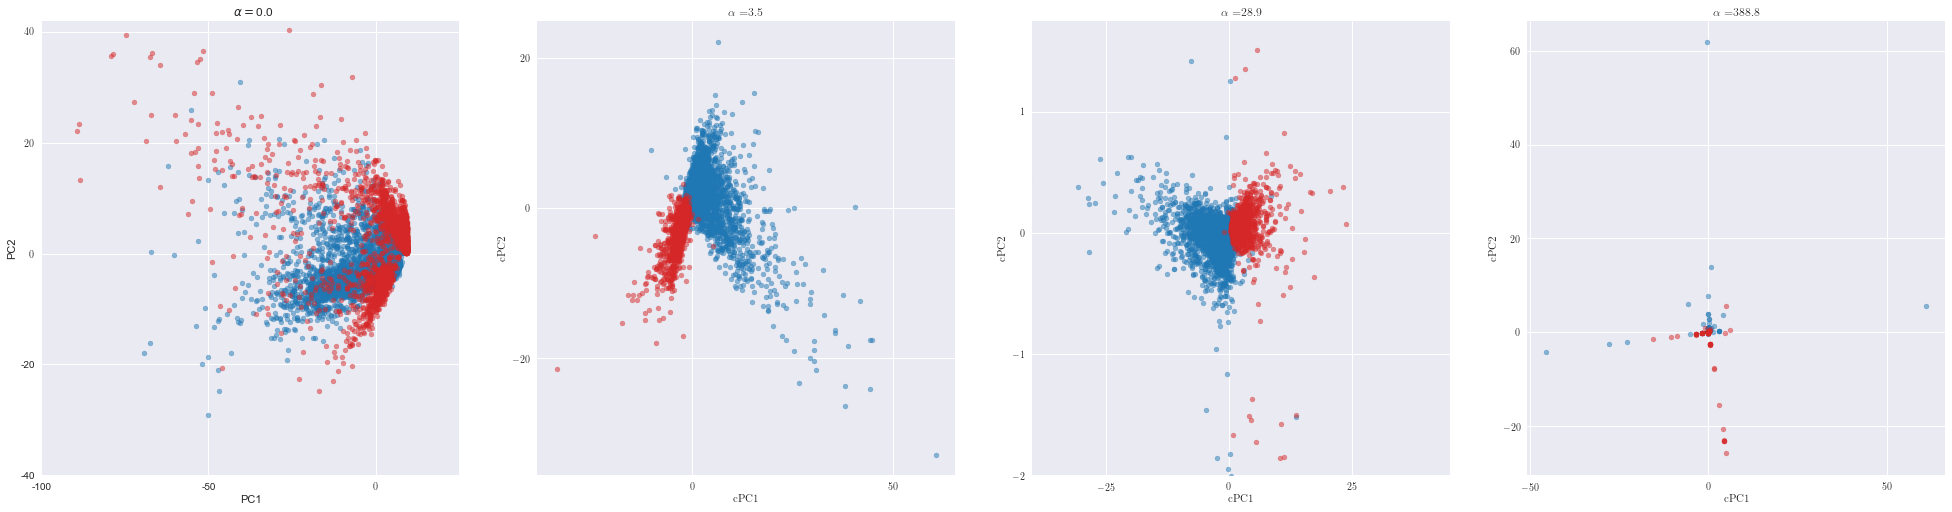

In [10]:
plt.figure(figsize=[28,8])
for j, (fg,bg) in enumerate(projected_data):
    plt.subplot(1,4,j+1)
    if (j==0):
        plt.title('PCA')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    else:
        plt.title('cPCA')
        plt.xlabel('cPC1')
        plt.ylabel('cPC2')
    if (j==1 or j==2):
        fg[:,0] = -fg[:,0]
    for i, l in enumerate((np.sort(np.unique(active_labels)))):
        idx = np.where(active_labels==l)[0]
        plt.scatter(fg[idx,0],fg[idx,1], color=colors[i], alpha=0.5, s=25)
    plt.title(r'$\alpha=$' +str(np.round(alphas[j],1)))
    matplotlib.rcParams.update({'font.size': 36})
    plt.locator_params(nbins=4, axis='x')
    plt.locator_params(nbins=6, axis='y')
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    if (j==0):
        plt.xlim([-100, 25])
        plt.ylim([-40, 42])
    if (j==2):
        plt.xlim([-40, 45])
        plt.ylim([-2, 1.75])   
    plt.tight_layout()    

Note that this code can be extended to more than two, as is done in Fig 3(c) and 3(d) of the paper. Here, for illustration, we run the same analysis with three groups of cells.

# Run Standard and Contrastive PCA (3 Groups)

In [ ]:
import matplotlib

active_file_idx = [1,2,3]
dataset = SingleCell(itemgetter(*active_file_idx)(fnames), [fnames[6]])
colors = ['#1f77b4','#d62728', '#2ca02c', '#ff7f0e']

projected_data, alphas = dataset.automated_cpca(max_log_alpha=3)
active_labels = dataset.get_active_labels()

0.0
0.0
0.0
3.45510729459
3.45510729459
3.45510729459
36.6524123708
36.6524123708
36.6524123708
388.815518031
388.815518031
388.815518031


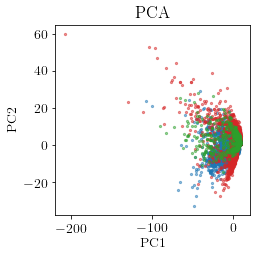

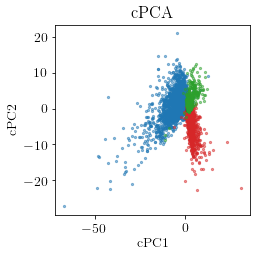

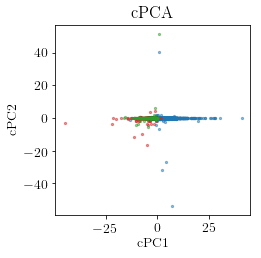

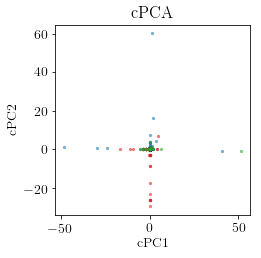

In [17]:
for j, (fg,bg) in enumerate(projected_data):
    plt.figure(figsize=[3.5,3.5])
    if (j==0):
        plt.title('PCA')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    else:
        plt.title('cPCA')
        plt.xlabel('cPC1')
        plt.ylabel('cPC2')
    for i, l in enumerate(np.sort(np.unique(active_labels))):
        idx = np.where(active_labels==l)[0]
        plt.scatter(fg[idx,0],fg[idx,1], color=colors[i], alpha=0.5, s=5)
    matplotlib.rcParams.update({'font.size': 14})
    plt.locator_params(nbins=4, axis='x')
    plt.locator_params(nbins=6, axis='y')
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')